## Basic Setting

In [1]:
import olefile
from konlpy.tag import Komoran
import re
from matplotlib import rc
import matplotlib.pyplot as plt
import pandas as pd

import zlib
import struct
from collections import Counter
from wordcloud import WordCloud

In [3]:
#글꼴 지정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 한글 파일 읽기

In [4]:
# 한글 파일 읽기
file_path = "/Users/hwangjaewon/Downloads/count_analylsis/recent_data/1번 문항.hwp"  # HWP 파일 경로 지정

In [5]:
def get_hwp_text(filename):
    f = olefile.OleFileIO(filename)
    dirs = f.listdir()

    # HWP 파일 검증
    if ["FileHeader"] not in dirs or \
            ["\x05HwpSummaryInformation"] not in dirs:
        raise Exception("Not Valid HWP.")

    # 문서 포맷 압축 여부 확인
    header = f.openstream("FileHeader")
    header_data = header.read()
    is_compressed = (header_data[36] & 1) == 1

    # Body Sections 불러오기
    nums = []
    for d in dirs:
        if d[0] == "BodyText":
            nums.append(int(d[1][len("Section"):]))
    sections = ["BodyText/Section" + str(x) for x in sorted(nums)]

    # 전체 text 추출
    text = ""
    for section in sections:
        bodytext = f.openstream(section)
        data = bodytext.read()
        if is_compressed:
            unpacked_data = zlib.decompress(data, -15)
        else:
            unpacked_data = data

        # 각 Section 내 text 추출
        section_text = ""
        i = 0
        size = len(unpacked_data)
        while i < size:
            header = struct.unpack_from("<I", unpacked_data, i)[0]
            rec_type = header & 0x3ff
            rec_len = (header >> 20) & 0xfff

            if rec_type in [67]:
                rec_data = unpacked_data[i + 4:i + 4 + rec_len]
                section_text += rec_data.decode('utf-16')
                section_text += "\n"

            i += 4 + rec_len

        text += section_text
        text += "\n"

    return text

In [106]:
text = get_hwp_text(file_path)

In [107]:
print(text)

捤獥    汤捯    가상융합산업 의 주요 성과 는 먼저 정부 주도의 전문 인력양성 사업이 진행되어 석사, 박사급 전문 인력양성 이 되었습니다. 이를 토대로 메타버스융합대학원 이 설립되면서 전문 인력양성과 시장 활성화 부분에서 좋은 결과를 얻었다고 생각합니다. 더 나아가 전문 인력양성 뿐만 아니라 산업 또는 기업 에 대한 지원 부분에서도, 현재는 다소 주춤하지만 메타버스나 VR, AR, XR 분야에 대한 지원과 노력이 있어 매우 긍정적 으로 평가 하고 있습니다.
사실 발전 이라기보다는 시장 을 형성 하는 데 있어 가장 큰 틀이 정부정책 이라고 볼 수 있습니다. 콘텐츠 나 메타버스 , 그리고 가상융합산업 자체가 시장 으로서 생태계 를 가져야 하는데, 우리나라 의 경우 정부정책이 방향성 을 가지고 가기 때문에 그에 대한 예산 도 투입되고 지원 전략들도 함께 수립됩니다. 그 결과 다양성 과 생태계 가 특정 킬러콘텐츠 나 한 기업이 주도하는 형식이 아닌, 국가에서 생태계 를 지원 하는 형태로 이루어져 전반적으로 가상융합산업 을 지탱하고 있습니다. 오히려 이것이 성과 라고 볼 수 있습니다.
기존 정부정책 에는 메타버스 와 관련된 구체적인 정책 가이드 가 없는 상태였습니다. 그러다 보니 하나씩 만들어가는 과정에서 기존 정부정책 법안 과 많이 충돌 을 일으켰던 것 같습니다. 2023년 말경에 가상융합산업진흥법 안이 통과되면서 가상융합산업 을 어떻게 바라볼 것이고, 어떤 것들이 가상융합산업 이며, 어떤 기준이 플랫폼 에 부합하는지에 대한 하위법령 들을 많이 논의 하기 시작했습니다. 이런 시행착오 를 통해 기반은 다져졌는데, 이를 시행 하는 데 있어 2025년에는 더 많은 기업들이 이런 법안 과 가이드 를 통해 안으로 들어와 발전적 인 정책에 따라갔으면 하는 바람입니다. 성과 적으로 봤을 때는 기반 이 마련 되었다고 볼 수 있습니다.
현 정부는 2021년부터 가상융합 발전 에 많은 투자 를 하여 지원사업 을 통해 콘텐츠 를 양성하고 있습니다. 현재는 현실형 콘텐츠 생성

## 형태소 분석

In [265]:
custom_dic_path = "/Users/hwangjaewon/Downloads/count_analylsis/custom_dic.txt"
komoran = Komoran(userdic=custom_dic_path)

In [266]:
#불용어 설정
stopwords = {"것", "이", "수", "하다", "있다", "되다", "그", "저", "등", "의", "를", 
             "은", "는", "가", "와", "에", "있", "하", "대하", "되", "보", "같", "크", "위하",
             "게", "때", "과", "치", "얻", "을", "관련", "들", "이제", "라고", "통하", "만들", "많", "이러", "계속", "좀",
             "그리고", "이나", "특히", "새롭", "생각", "늘", "물", "오", "가지", "내", "가지", "예", "보이", "지금", "형태",
             "없", "두", "서", "함", "넘", "밎"}

In [267]:
# 단어 매핑 (동일한 단어로 처리하고 싶은 경우)
word_mapping = {
    "R&D사업": "R&D", 
}

In [268]:
# 특수문자 포함 단어 추출 + 사용자 지정 단어 추가
def get_special_tokens(text, additional_tokens=None):
    """
    특수문자 포함 단어와 사용자 지정 단어를 결합하여 반환
    - text: 분석할 텍스트
    - additional_tokens: 사용자가 추가로 지정하고 싶은 단어 리스트
    """
    # 특수문자를 포함한 단어 추출
    special_tokens = re.findall(r"\b\w+[&\-]\w+\b", text)  # 예: R&D, K-콘텐츠
    
    # 사용자 지정 단어 추가
    if additional_tokens:
        special_tokens.extend(additional_tokens)
    
    # 중복 제거 후 반환
    return list(set(special_tokens))


In [269]:
additional_tokens = ["AI", "실감미디어"]  # 사용자가 추가하고 싶은 단어
special_tokens = get_special_tokens(text, additional_tokens=additional_tokens)

In [270]:
# Komoran 분석용 텍스트 전처리
cleaned_text = re.sub(r"[^\w\sㄱ-ㅎㅏ-ㅣ가-힣]", "", text)  # 특수문자 제거
cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()  # 공백 정리

# Komoran 품사 태깅
pos_tags = komoran.pos(cleaned_text)


# 원하는 품사 필터링
desired_pos = {"NNG", "NNP", "VV", "VA", "MAG", "MAJ", "XR"}  # 명사, 동사, 형용사, 부사 등
filtered_tokens = [word for word, tag in pos_tags if tag in desired_pos and word.lower() not in stopwords]


# Komoran 결과와 특수문자 포함 단어 병합
all_tokens = filtered_tokens + special_tokens

# 단어 매핑 적용
mapped_tokens = [word_mapping.get(word, word) for word in all_tokens]


In [271]:
# 빈도 분석 함수
def analyze_frequency(tokens):
    """
    tokens: 단어 리스트
    한 글자 단어는 제외하고 빈도 분석 수행
    """
    filtered_tokens = [token for token in tokens if len(token) > 1]  # 한 글자 단어 제거
    counter = Counter(filtered_tokens)
    return counter.most_common()

# 시각화 함수
def visualize_frequencies(frequencies,q_num, top_n=10, output_file=None):
    df = pd.DataFrame(frequencies[:top_n], columns=["단어", "빈도"])
    # 가로 크기 확대
    plt.figure(figsize=(15, 6))  # 가로 15, 세로 6
    ax = df.plot.bar(x="단어", y="빈도", legend=False, figsize=(15, 6))
    
    # x축 레이블 회전 및 간격 조정
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # 45도 회전 및 오른쪽 정렬
    
    
    plt.title(f"{q_num}단어 빈도 분석")
    plt.xlabel("단어")
    plt.ylabel("빈도")
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file, format='png', dpi=300, bbox_inches='tight')  # 고해상도로 저장
        print(f"그래프가 '{output_file}'에 저장되었습니다.")

    plt.show()

In [272]:
# 빈도 분석 결과를 텍스트로 저장하는 함수
def save_frequencies_to_text(frequencies, output_file):
    """
    빈도 분석 결과를 텍스트 파일로 저장
    frequencies: 빈도 데이터 (리스트 of 튜플)
    output_file: 저장할 파일 경로
    """
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("단어\t빈도\n")  # 헤더 추가
        for word, freq in frequencies:
            f.write(f"{word}\t{freq}\n")
    print(f"빈도 분석 결과가 '{output_file}'에 저장되었습니다.")

단어 빈도 분석 결과: [('정부', 47), ('산업', 45), ('성과', 41), ('가상융합산업', 36), ('지원', 26), ('부분', 24), ('콘텐츠', 24), ('가상융합산업진흥법', 20), ('기술', 19), ('사업', 18), ('메타버스', 18), ('정부정책', 18), ('노력', 17), ('발전', 17), ('많이', 16), ('기반', 16), ('진흥', 16), ('기업', 15), ('마련', 14), ('현재', 13), ('정책', 13), ('주요', 12), ('인력양성', 11), ('진행', 11), ('생태계', 11), ('예산', 11), ('규제', 11), ('분야', 10), ('매우', 10), ('긍정적', 10), ('가장', 10), ('투자', 10), ('융합', 10), ('교육', 9), ('중요', 9), ('가상', 9), ('기존', 8), ('시행', 8), ('측면', 8), ('필요', 8), ('다양', 8), ('개발', 8), ('평가', 7), ('자체', 7), ('수립', 7), ('이루어지', 7), ('가상융합', 7), ('경험', 7), ('제정', 7), ('역할', 7), ('기여', 7), ('사회', 7), ('가능', 7), ('서비스', 7), ('대학', 7), ('인력', 7), ('관심', 7), ('선제적', 7), ('일단', 7), ('과학기술정보통신부', 7), ('시장', 6), ('활성화', 6), ('결과', 6), ('또는', 6), ('경우', 6), ('전반', 6), ('통과', 6), ('효과', 6), ('조성', 6), ('인프라', 6), ('이해', 6), ('나오', 6), ('확대', 6), ('전문', 5), ('VR', 5), ('AR', 5), ('시작', 5), ('현실', 5), ('실제', 5), ('상황', 5), ('사람', 5), ('법적근거', 5), ('육성', 5), ('법

<Figure size 1500x600 with 0 Axes>

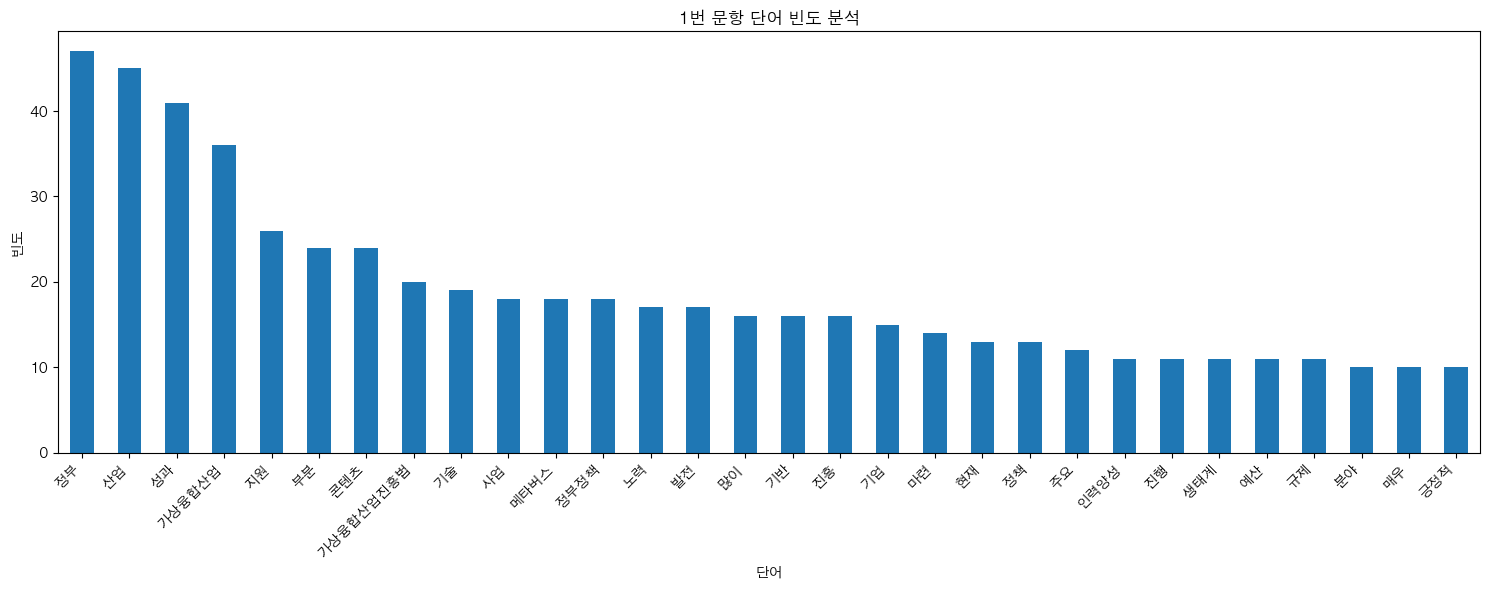

빈도 분석 결과가 '/Users/hwangjaewon/Downloads/count_analylsis/result/1번/count_freq.txt'에 저장되었습니다.


In [273]:
# 빈도 분석
frequencies = analyze_frequency(mapped_tokens)

print("단어 빈도 분석 결과:", frequencies)

# 시각화
visualize_frequencies(frequencies,"1번 문항 ",top_n=30, output_file="/Users/hwangjaewon/Downloads/count_analylsis/result/1번/count_plot.png")
# 빈도 분석 결과를 텍스트로 저장
save_frequencies_to_text(frequencies, output_file="/Users/hwangjaewon/Downloads/count_analylsis/result/1번/count_freq.txt")

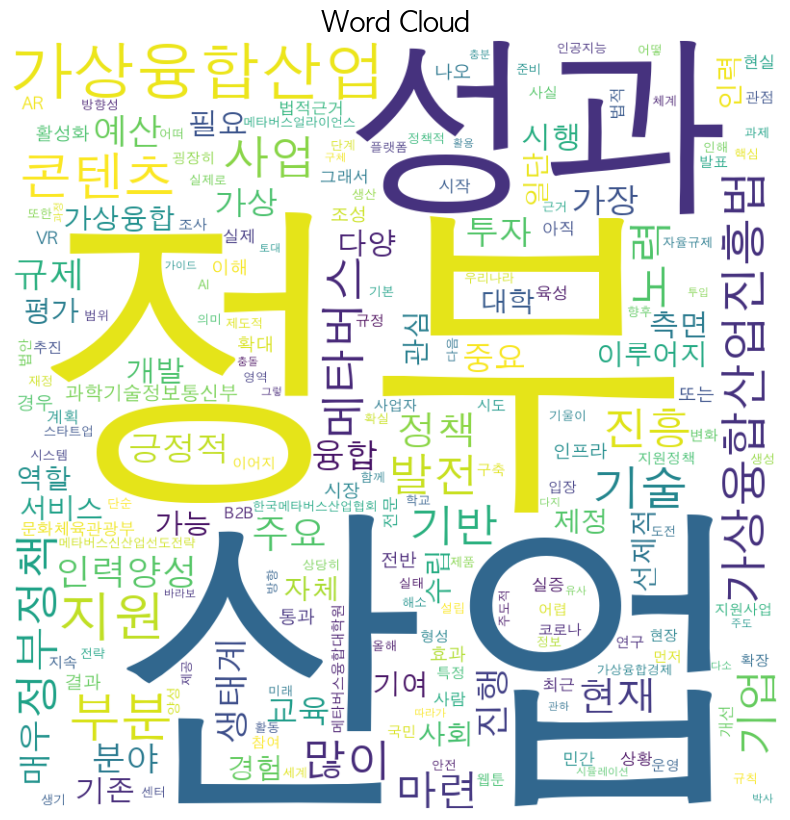

In [274]:
# 워드 클라우드 생성 함수
def generate_wordcloud(frequencies, font_path=None, output_file=None):
    """
    frequencies: 단어 빈도 데이터 (리스트 of 튜플)
    font_path: 한글 폰트 경로 (한글 텍스트일 경우 필요)
    output_file: 저장할 파일 경로 (optional)
    """
    # 워드 클라우드 생성
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        font_path=font_path  # 한글 폰트를 지정해야 깨짐 방지
    ).generate_from_frequencies(dict(frequencies))
    
    # 워드 클라우드 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # 축 숨기기
    plt.title("Word Cloud", fontsize=20)
    
    if output_file:
        plt.savefig(output_file)
    plt.show()


# 워드 클라우드 생성
generate_wordcloud(
    frequencies,
    font_path="/Library/Fonts/AppleGothic.ttf", 
    output_file="/Users/hwangjaewon/Downloads/count_analylsis/result/1번/wordcloud.png"  # 파일로 저장하고 싶으면 경로 지정 (예: "wordcloud.png")
)

In [187]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import re
from konlpy.tag import Komoran
from collections import Counter
import pandas as pd

생성된 엣지: [('가상융합산업', '주요'), ('가상융합산업', '성과'), ('주요', '성과'), ('주요', '성과'), ('주요', '먼저'), ('성과', '먼저'), ('성과', '먼저'), ('성과', '정부'), ('먼저', '정부'), ('먼저', '정부'), ('먼저', '주도'), ('정부', '주도'), ('정부', '주도'), ('정부', '전문'), ('주도', '전문'), ('주도', '전문'), ('주도', '인력양성'), ('전문', '인력양성'), ('전문', '인력양성'), ('전문', '사업'), ('인력양성', '사업'), ('인력양성', '사업'), ('인력양성', '진행'), ('사업', '진행'), ('사업', '진행'), ('사업', '석사'), ('진행', '석사'), ('진행', '석사'), ('진행', '박사'), ('석사', '박사'), ('석사', '박사'), ('석사', '급'), ('박사', '급'), ('박사', '급'), ('박사', '전문'), ('급', '전문'), ('급', '전문'), ('급', '인력양성'), ('전문', '인력양성'), ('전문', '인력양성'), ('전문', '토대'), ('인력양성', '토대'), ('인력양성', '토대'), ('인력양성', '메타버스융합대학원'), ('토대', '메타버스융합대학원'), ('토대', '메타버스융합대학원'), ('토대', '설립'), ('메타버스융합대학원', '설립'), ('메타버스융합대학원', '설립'), ('메타버스융합대학원', '전문'), ('설립', '전문'), ('설립', '전문'), ('설립', '인력양성'), ('전문', '인력양성'), ('전문', '인력양성'), ('전문', '시장'), ('인력양성', '시장'), ('인력양성', '시장'), ('인력양성', '활성화'), ('시장', '활성화'), ('시장', '활성화'), ('시장', '부분'), ('활성화', '부분'), ('활성화', '부분'), ('활성화', '좋

findfont: Font family '/Library/Fonts/AppleGothic.ttf' not found.
findfont: Font family '/Library/Fonts/AppleGothic.ttf' not found.
/Users/hwangjaewon/Downloads/count_analylsis/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hwangjaewon/Downloads/count_analylsis/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hwangjaewon/Downloads/count_analylsis/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hwangjaewon/Downloads/count_analylsis/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54633 (\N{HANGUL SY

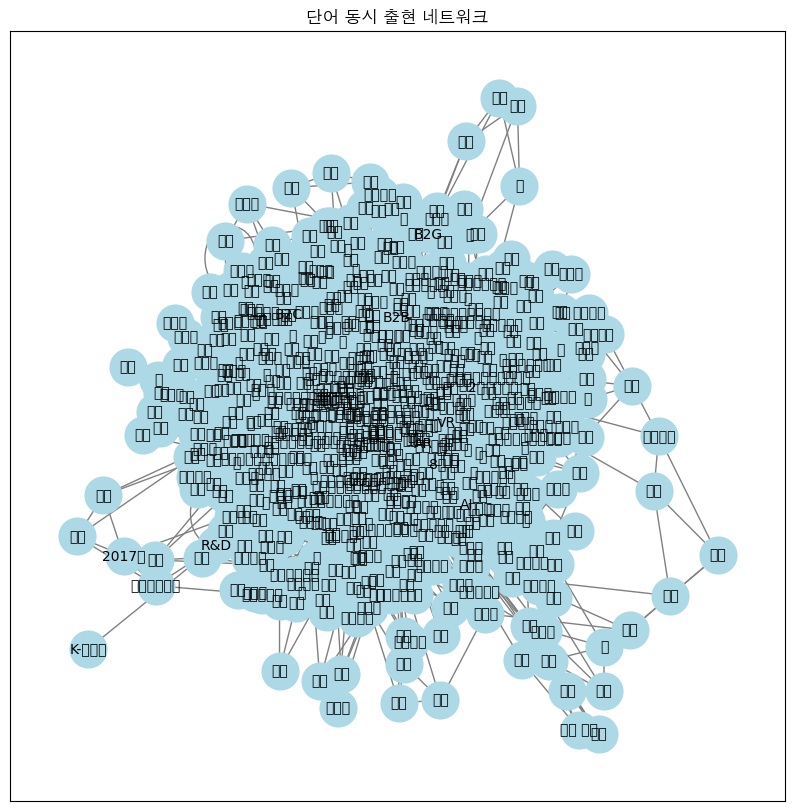

In [259]:
# 네트워크 분석 데이터 준비
def build_cooccurrence_network(tokens, window_size=2):
    edges = []
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i + window_size]
        edges.extend(combinations(window, 2))
    return edges

# 동시 출현 네트워크 생성
edges = build_cooccurrence_network(mapped_tokens, window_size=3)
print("생성된 엣지:", edges)

# 네트워크 그래프 생성
def visualize_network(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)  # 그래프 레이아웃
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="/Library/Fonts/AppleGothic.ttf")
    plt.title("단어 동시 출현 네트워크")
    plt.show()

# 네트워크 시각화
visualize_network(edges)

In [101]:
# Komoran 분석용 텍스트 전처리
cleaned_text = re.sub(r"[^\w\sㄱ-ㅎㅏ-ㅣ가-힣]", "", text)  # 특수문자 제거
cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()  # 공백 정리

In [102]:
# Komoran 품사 태깅
pos_tags = komoran.pos(cleaned_text)
print("Komoran 태깅 결과:", pos_tags)

Komoran 태깅 결과: [('捤獥汤捯', 'SH'), ('가상융합산업', 'NNP'), ('의', 'NNG'), ('주요', 'XR'), ('성과', 'NNP'), ('늘', 'VV'), ('ㄴ', 'ETM'), ('먼저', 'MAG'), ('정부', 'NNP'), ('주도', 'NNG'), ('의', 'JKG'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('사업', 'NNP'), ('이', 'JKS'), ('진행', 'NNG'), ('되', 'XSV'), ('어', 'EC'), ('석사', 'NNP'), ('박사', 'NNG'), ('급', 'NNG'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('이', 'MM'), ('되', 'VV'), ('었', 'EP'), ('습니다', 'EC'), ('이', 'NP'), ('를', 'JKO'), ('토대', 'NNG'), ('로', 'JKB'), ('메타버스융합대학원', 'NNP'), ('이', 'MM'), ('설립', 'NNG'), ('되', 'XSV'), ('면서', 'EC'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('과', 'JC'), ('시장', 'NNG'), ('활성화', 'NNP'), ('부분', 'NNG'), ('에서', 'JKB'), ('좋', 'VA'), ('은', 'ETM'), ('결과', 'NNG'), ('를', 'JKO'), ('얻', 'VV'), ('었', 'EP'), ('다고', 'EC'), ('생각', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EC'), ('더', 'MAG'), ('나아가', 'VV'), ('아', 'EC'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('뿐', 'NNB'), ('만', 'JX'), ('아니', 'VCN'), ('라', 'EC'), ('산업', 'NNP'), ('또는', 'MAJ'), ('기업', 'NNG'), ('에', 'JKB'), ('대하', 'VV'), ('ㄴ',

In [103]:
# 원하는 품사 필터링
desired_pos = {"NNG", "NNP", "VV", "VA",  "XR"}  # 명사, 동사, 형용사, 부사 등
filtered_tokens = [word for word, tag in pos_tags if tag in desired_pos and word.lower() not in stopwords]
print("필터링된 단어:", filtered_tokens)

필터링된 단어: ['가상융합산업', '주요', '성과', '늘', '정부', '주도', '전문', '인력양성', '사업', '진행', '석사', '박사', '급', '전문', '인력양성', '토대', '메타버스융합대학원', '설립', '전문', '인력양성', '시장', '활성화', '부분', '좋', '결과', '생각', '나아가', '전문', '인력양성', '산업', '기업', '지원', '부분', '현재', '메타버스', 'VR', 'AR', '분야', '지원', '노력', '긍정적', '평가', '사실', '발전', '시장', '을', '형성', '틀', '정부정책', '콘텐츠', '메타버스', '가상융합산업', '자체', '시장', '생태계', '가지', '우리나라', '경우', '정부정책', '방향성', '을', '가지', '예산', '도', '투입', '지원', '전략', '수립', '결과', '다양성', '생태계', '특정', '킬러콘텐츠', '기업', '주도', '형식', '국가', '생태계', '지원', '형태', '이루어지', '전반', '가상융합산업', '을', '지탱', '성과', '라고', '기존', '정부정책', '메타버스', '오', '관련', '구체', '정책', '가이드', '없', '상태', '그렇', '보니', '만들', '과정', '기존', '정부정책', '법안', '충돌', '을', '일으키', '말', '가상융합산업진흥법', '안', '통과', '가상융합산업', '을', '어떻', '바라보', '가상융합산업', '기준', '플랫폼', '부합', '하위법령', '들', '논의', '시작', '시행착오', '통하', '기반', '다지', '시행', '많', '기업', '법안', '가이드', '통하', '안', '들어오', '발전', '인', '정책', '따라가', '바람', '성과', '기반', '마련', '정부', '가상융합', '발전', '많', '투자', '지원사업', '을', '통하', '콘텐츠', '양성', '현재'

In [104]:
# Komoran 결과와 특수문자 포함 단어 병합
final_tokens = list(set(filtered_tokens + special_tokens))

# 단어 매핑 적용
final_tokens = [word_mapping.get(word, word) for word in final_tokens]
print("매핑 처리된 단어 리스트:", final_tokens)

매핑 처리된 단어 리스트: ['사항', '재개', '가능', '이루어지', '다양성', '시간', '기여', '주목', '함', '지원책', '서', '뚜렷', '이후', '운영', '초점', '확장', '도전', '법제도', '학교', '노력', '인력', '설정', '가상융합산업', '마련', '모습', '동남아', '예상', '2017년', '부가가치', '쉽', '법안', 'AI', '통칭', '산업', '가상융합산업진흥법', '이렇', '양성', '높', '해보', '미래', '발효', '지원', '불확실성', '파악', '원활', '변화', '게임', '권위', '전달', '사이', '맞', '걸', '제가', '실제', '시행', '문화', '지원사업', '명확', '지원정책', '실질', '가상 세계', '드릴', '유치', '시기', '해당', '기반', '생태계', '책정', '종사', '모이', 'VR', '단순', '진흥법', '국회', '새롭', '적용', '시작', '마음', '시범', '생성', '예체능', '이러', '토대', '방향', '따라가', '시너지', '자율규제', '차원', '보이', '노출', '의지', '부재', '전공', '가시', '상용화', '가상융합', '실력', '빠르', '사업', 'B2G', '교수', '이든', '가지', '그렇', '중소기업', '측정', '로', '실현', '맞추', '입법', '목격', '메타버스허브', '사업자', '조사', '시키', '속', '장려', '개정', '이다', '허용', '면', '과제', '중장기', '기존', '활용', '공유', '유능', '추가', '형식', '과학', '을', '출시', '따르', '기대', '기구', '한국메타버스산업협회', '정책적', '사실', '정해', '이랑', '로드맵', '불구', '발표', '대학', '향후', '조차', '소통', '메타버스', '협회', '어떠', '초기', '발휘', '적극', '이해관계자', '생기',

In [105]:
final_tokens

['사항',
 '재개',
 '가능',
 '이루어지',
 '다양성',
 '시간',
 '기여',
 '주목',
 '함',
 '지원책',
 '서',
 '뚜렷',
 '이후',
 '운영',
 '초점',
 '확장',
 '도전',
 '법제도',
 '학교',
 '노력',
 '인력',
 '설정',
 '가상융합산업',
 '마련',
 '모습',
 '동남아',
 '예상',
 '2017년',
 '부가가치',
 '쉽',
 '법안',
 'AI',
 '통칭',
 '산업',
 '가상융합산업진흥법',
 '이렇',
 '양성',
 '높',
 '해보',
 '미래',
 '발효',
 '지원',
 '불확실성',
 '파악',
 '원활',
 '변화',
 '게임',
 '권위',
 '전달',
 '사이',
 '맞',
 '걸',
 '제가',
 '실제',
 '시행',
 '문화',
 '지원사업',
 '명확',
 '지원정책',
 '실질',
 '가상 세계',
 '드릴',
 '유치',
 '시기',
 '해당',
 '기반',
 '생태계',
 '책정',
 '종사',
 '모이',
 'VR',
 '단순',
 '진흥법',
 '국회',
 '새롭',
 '적용',
 '시작',
 '마음',
 '시범',
 '생성',
 '예체능',
 '이러',
 '토대',
 '방향',
 '따라가',
 '시너지',
 '자율규제',
 '차원',
 '보이',
 '노출',
 '의지',
 '부재',
 '전공',
 '가시',
 '상용화',
 '가상융합',
 '실력',
 '빠르',
 '사업',
 'B2G',
 '교수',
 '이든',
 '가지',
 '그렇',
 '중소기업',
 '측정',
 '로',
 '실현',
 '맞추',
 '입법',
 '목격',
 '메타버스허브',
 '사업자',
 '조사',
 '시키',
 '속',
 '장려',
 '개정',
 '이다',
 '허용',
 '면',
 '과제',
 '중장기',
 '기존',
 '활용',
 '공유',
 '유능',
 '추가',
 '형식',
 '과학',
 '을',
 '출시',
 '따르',
 '기대',
 '기구',
 '한국메타버스산업협회',


단어 빈도 분석 결과: [('R&D', 2), ('사항', 1), ('재개', 1), ('가능', 1), ('이루어지', 1), ('다양성', 1), ('시간', 1), ('기여', 1), ('주목', 1), ('치', 1), ('함', 1), ('지원책', 1), ('서', 1), ('뚜렷', 1), ('이후', 1), ('운영', 1), ('초점', 1), ('얻', 1), ('확장', 1), ('도전', 1), ('법제도', 1), ('학교', 1), ('노력', 1), ('인력', 1), ('설정', 1), ('가상융합산업', 1), ('마련', 1), ('모습', 1), ('동남아', 1), ('예상', 1), ('2017년', 1), ('부가가치', 1), ('쉽', 1), ('법안', 1), ('AI', 1), ('통칭', 1), ('산업', 1), ('가상융합산업진흥법', 1), ('이렇', 1), ('양성', 1), ('높', 1), ('해보', 1), ('미래', 1), ('발효', 1), ('지원', 1), ('불확실성', 1), ('파악', 1), ('원활', 1), ('변화', 1), ('게임', 1), ('권위', 1), ('전달', 1), ('사이', 1), ('맞', 1), ('걸', 1), ('제가', 1), ('실제', 1), ('시행', 1), ('문화', 1), ('지원사업', 1), ('명확', 1), ('지원정책', 1), ('실질', 1), ('가상 세계', 1), ('드릴', 1), ('유치', 1), ('시기', 1), ('해당', 1), ('기반', 1), ('생태계', 1), ('책정', 1), ('종사', 1), ('모이', 1), ('VR', 1), ('단순', 1), ('진흥법', 1), ('국회', 1), ('새롭', 1), ('적용', 1), ('시작', 1), ('마음', 1), ('시범', 1), ('생성', 1), ('예체능', 1), ('이러', 1), ('토대', 1), ('방향', 1), ('

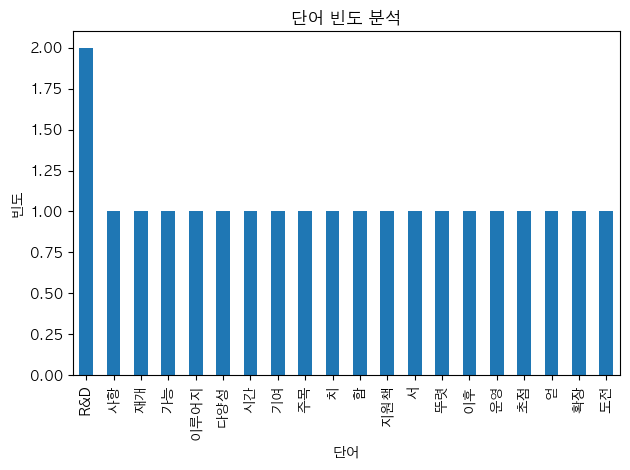

In [ ]:


# 빈도 분석
frequencies = analyze_frequency(final_tokens)
print("단어 빈도 분석 결과:", frequencies)

# 시각화
visualize_frequencies(frequencies, top_n=20)

In [63]:
# Komoran 분석에서 누락된 단어를 추가
cleaned_text = re.sub(r"[^\w\sㄱ-ㅎㅏ-ㅣ가-힣]", "", text)
pos_tags = komoran.pos(cleaned_text)
filtered_tokens = [word for word, tag in pos_tags if tag in {"NNG", "NNP", "VV", "VA", "MAG", "MAJ", "XR"}]
final_tokens = filtered_tokens + special_tokens
print("최종 결과:", final_tokens)

최종 결과: ['가상융합산업', '의', '주요', '성과', '늘', '먼저', '정부', '주도', '전문', '인력양성', '사업', '진행', '석사', '박사', '급', '전문', '인력양성', '되', '토대', '메타버스융합대학원', '설립', '전문', '인력양성', '시장', '활성화', '부분', '좋', '결과', '얻', '생각', '더', '나아가', '전문', '인력양성', '산업', '또는', '기업', '대하', '지원', '부분', '현재', '다소', '주춤', '메타버스', 'VR', 'AR', '분야', '대하', '지원', '노력', '있', '매우', '긍정적', '평가', '하', '있', '사실', '발전', '시장', '을', '형성', '하', '있', '가장', '크', '틀', '정부정책', '보', '있', '콘텐츠', '메타버스', '그리고', '가상융합산업', '자체', '시장', '생태계', '가지', '하', '우리나라', '의', '경우', '정부정책', '방향성', '을', '가지', '가', '대하', '예산', '도', '투입', '지원', '전략', '함께', '수립', '결과', '다양성', '과', '생태계', '가', '특정', '킬러콘텐츠', '기업', '주도', '형식', '국가', '생태계', '지원', '하', '형태', '이루어지', '전반', '가상융합산업', '을', '지탱', '있', '오히려', '성과', '라고', '보', '있', '기존', '정부정책', '에', '메타버스', '오', '관련', '구체', '정책', '가이드', '가', '없', '상태', '그렇', '보니', '만들', '과정', '기존', '정부정책', '법안', '과', '많이', '충돌', '을', '일으키', '같', '말', '가상융합산업진흥법', '안', '통과', '가상융합산업', '을', '어떻', '바라보', '가상융합산업', '기준', '플랫폼', '부합', '대하', '하위법령

In [65]:
cleaned_text

'捤獥汤捯가상융합산업 의 주요 성과 는 먼저 정부 주도의 전문 인력양성 사업이 진행되어 석사 박사급 전문 인력양성 이 되었습니다 이를 토대로 메타버스융합대학원 이 설립되면서 전문 인력양성과 시장 활성화 부분에서 좋은 결과를 얻었다고 생각합니다 더 나아가 전문 인력양성 뿐만 아니라 산업 또는 기업 에 대한 지원 부분에서도 현재는 다소 주춤하지만 메타버스나 VR AR XR 분야에 대한 지원과 노력이 있어 매우 긍정적 으로 평가 하고 있습니다\r\n사실 발전 이라기보다는 시장 을 형성 하는 데 있어 가장 큰 틀이 정부정책 이라고 볼 수 있습니다 콘텐츠 나 메타버스  그리고 가상융합산업 자체가 시장 으로서 생태계 를 가져야 하는데 우리나라 의 경우 정부정책이 방향성 을 가지고 가기 때문에 그에 대한 예산 도 투입되고 지원 전략들도 함께 수립됩니다 그 결과 다양성 과 생태계 가 특정 킬러콘텐츠 나 한 기업이 주도하는 형식이 아닌 국가에서 생태계 를 지원 하는 형태로 이루어져 전반적으로 가상융합산업 을 지탱하고 있습니다 오히려 이것이 성과 라고 볼 수 있습니다\r\n기존 정부정책 에는 메타버스 와 관련된 구체적인 정책 가이드 가 없는 상태였습니다 그러다 보니 하나씩 만들어가는 과정에서 기존 정부정책 법안 과 많이 충돌 을 일으켰던 것 같습니다 2023년 말경에 가상융합산업진흥법 안이 통과되면서 가상융합산업 을 어떻게 바라볼 것이고 어떤 것들이 가상융합산업 이며 어떤 기준이 플랫폼 에 부합하는지에 대한 하위법령 들을 많이 논의 하기 시작했습니다 이런 시행착오 를 통해 기반은 다져졌는데 이를 시행 하는 데 있어 2025년에는 더 많은 기업들이 이런 법안 과 가이드 를 통해 안으로 들어와 발전적 인 정책에 따라갔으면 하는 바람입니다 성과 적으로 봤을 때는 기반 이 마련 되었다고 볼 수 있습니다\r\n현 정부는 2021년부터 가상융합 발전 에 많은 투자 를 하여 지원사업 을 통해 콘텐츠 를 양성하고 있습니다 현재는 현실형 콘텐츠 생성 부분에서 많은 성과를 내고 있다고 생각합니다

In [66]:
file_name = './test.txt'
with open(file_name, 'w+') as file:
    file.write('\n'.join(final_tokens))  # '\n' 대신 ', '를 사용하면 줄바꿈이 아닌 ', '를 기준으로 문자열 구분함

In [67]:
# 빈도 분석 함수
def analyze_frequency(tokens):
    counter = Counter(tokens)
    return counter.most_common()

# 시각화 함수
def visualize_frequencies(frequencies, top_n=10, output_file=None):
    df = pd.DataFrame(frequencies[:top_n], columns=["단어", "빈도"])
    df.plot.bar(x="단어", y="빈도", legend=False)
    plt.title("단어 빈도 분석")
    plt.xlabel("단어")
    plt.ylabel("빈도")
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file)
    plt.show()



In [69]:
freq = analyze_frequency(final_tokens)
freq 

[('있', 153),
 ('하', 92),
 ('을', 48),
 ('정부', 47),
 ('산업', 45),
 ('성과', 41),
 ('생각', 39),
 ('가상융합산업', 36),
 ('되', 36),
 ('대하', 35),
 ('지원', 26),
 ('보', 25),
 ('부분', 24),
 ('콘텐츠', 24),
 ('의', 22),
 ('위하', 22),
 ('관련', 21),
 ('통하', 21),
 ('만들', 20),
 ('같', 20),
 ('가상융합산업진흥법', 20),
 ('이제', 20),
 ('라고', 19),
 ('기술', 19),
 ('사업', 18),
 ('메타버스', 18),
 ('정부정책', 18),
 ('노력', 17),
 ('발전', 17),
 ('들', 17),
 ('많이', 16),
 ('기반', 16),
 ('진흥', 16),
 ('기업', 15),
 ('가', 15),
 ('많', 14),
 ('마련', 14),
 ('현재', 13),
 ('정책', 13),
 ('주요', 12),
 ('이러', 12),
 ('인력양성', 11),
 ('진행', 11),
 ('생태계', 11),
 ('예산', 11),
 ('규제', 11),
 ('특히', 11),
 ('분야', 10),
 ('매우', 10),
 ('긍정적', 10),
 ('가장', 10),
 ('크', 10),
 ('그리고', 10),
 ('투자', 10),
 ('보이', 10),
 ('융합', 10),
 ('교육', 9),
 ('중요', 9),
 ('이나', 9),
 ('지금', 9),
 ('새롭', 9),
 ('가상', 9),
 ('가지', 8),
 ('과', 8),
 ('형태', 8),
 ('기존', 8),
 ('시행', 8),
 ('측면', 8),
 ('필요', 8),
 ('다양', 8),
 ('개발', 8),
 ('평가', 7),
 ('자체', 7),
 ('수립', 7),
 ('이루어지', 7),
 ('가상융합', 7),
 ('경험', 7),
 ('제정'

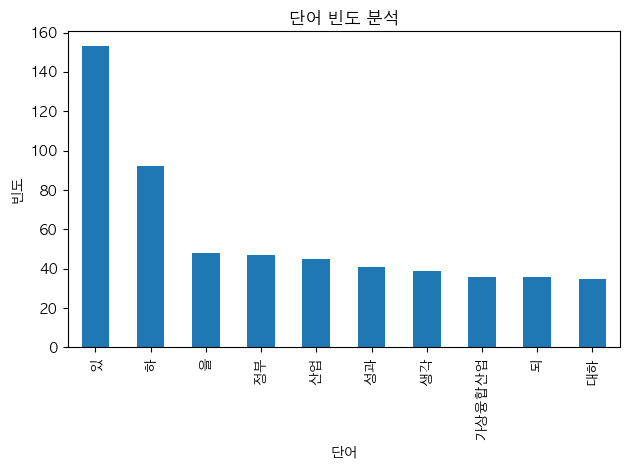

In [70]:
visualize_frequencies(freq , top_n=10, output_file=None)

In [48]:
test_word = "R&D"
pos_tags = komoran.pos(test_word)
print("태깅 결과:", pos_tags)

태깅 결과: [('R', 'SL'), ('&', 'SW'), ('D', 'SL')]


In [40]:
exceptions = {"R&D"}
cleaned_text = " ".join([word if word in exceptions else re.sub(r"[^\w\sㄱ-ㅎㅏ-ㅣ가-힣]", "", word) for word in text.split()])

In [45]:
cleaned_text

'捤獥汤捯가상융합산업 의 주요 성과 는 먼저 정부 주도의 전문 인력양성 사업이 진행되어 석사 박사급 전문 인력양성 이 되었습니다 이를 토대로 메타버스융합대학원 이 설립되면서 전문 인력양성과 시장 활성화 부분에서 좋은 결과를 얻었다고 생각합니다 더 나아가 전문 인력양성 뿐만 아니라 산업 또는 기업 에 대한 지원 부분에서도 현재는 다소 주춤하지만 메타버스나 VR AR XR 분야에 대한 지원과 노력이 있어 매우 긍정적 으로 평가 하고 있습니다 사실 발전 이라기보다는 시장 을 형성 하는 데 있어 가장 큰 틀이 정부정책 이라고 볼 수 있습니다 콘텐츠 나 메타버스  그리고 가상융합산업 자체가 시장 으로서 생태계 를 가져야 하는데 우리나라 의 경우 정부정책이 방향성 을 가지고 가기 때문에 그에 대한 예산 도 투입되고 지원 전략들도 함께 수립됩니다 그 결과 다양성 과 생태계 가 특정 킬러콘텐츠 나 한 기업이 주도하는 형식이 아닌 국가에서 생태계 를 지원 하는 형태로 이루어져 전반적으로 가상융합산업 을 지탱하고 있습니다 오히려 이것이 성과 라고 볼 수 있습니다 기존 정부정책 에는 메타버스 와 관련된 구체적인 정책 가이드 가 없는 상태였습니다 그러다 보니 하나씩 만들어가는 과정에서 기존 정부정책 법안 과 많이 충돌 을 일으켰던 것 같습니다 2023년 말경에 가상융합산업진흥법 안이 통과되면서 가상융합산업 을 어떻게 바라볼 것이고 어떤 것들이 가상융합산업 이며 어떤 기준이 플랫폼 에 부합하는지에 대한 하위법령 들을 많이 논의 하기 시작했습니다 이런 시행착오 를 통해 기반은 다져졌는데 이를 시행 하는 데 있어 2025년에는 더 많은 기업들이 이런 법안 과 가이드 를 통해 안으로 들어와 발전적 인 정책에 따라갔으면 하는 바람입니다 성과 적으로 봤을 때는 기반 이 마련 되었다고 볼 수 있습니다 현 정부는 2021년부터 가상융합 발전 에 많은 투자 를 하여 지원사업 을 통해 콘텐츠 를 양성하고 있습니다 현재는 현실형 콘텐츠 생성 부분에서 많은 성과를 내고 있다고 생각합니다 건축 의료 교육

In [42]:
# 형태소 분석 수행 (명사, 형용사, 동사, 부사 포함)
try:
    pos_tags = komoran.pos(cleaned_text)  # Komoran으로 품사 태깅
    print("품사 태깅 결과:", pos_tags)

    # 원하는 품사 필터링 (예: 명사, 형용사, 동사, 부사)
    desired_pos = {"NNG", "NNP", "VV", "VA", "MAG", "MAJ", "XR"}  # 명사, 동사, 형용사, 부사 등
    filtered_tokens = [word for word, tag in pos_tags if tag in desired_pos]
    print("필터링된 단어:", filtered_tokens)
except Exception as e:
    print(f"Komoran 처리 오류: {e}")
    filtered_tokens = []

품사 태깅 결과: [('捤獥汤捯', 'SH'), ('가상융합산업', 'NNP'), ('의', 'NNG'), ('주요', 'XR'), ('성과', 'NNP'), ('늘', 'VV'), ('ㄴ', 'ETM'), ('먼저', 'MAG'), ('정부', 'NNP'), ('주도', 'NNG'), ('의', 'JKG'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('사업', 'NNP'), ('이', 'JKS'), ('진행', 'NNG'), ('되', 'XSV'), ('어', 'EC'), ('석사', 'NNP'), ('박사', 'NNG'), ('급', 'NNG'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('이', 'MM'), ('되', 'VV'), ('었', 'EP'), ('습니다', 'EC'), ('이', 'NP'), ('를', 'JKO'), ('토대', 'NNG'), ('로', 'JKB'), ('메타버스융합대학원', 'NNP'), ('이', 'MM'), ('설립', 'NNG'), ('되', 'XSV'), ('면서', 'EC'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('과', 'JC'), ('시장', 'NNG'), ('활성화', 'NNP'), ('부분', 'NNG'), ('에서', 'JKB'), ('좋', 'VA'), ('은', 'ETM'), ('결과', 'NNG'), ('를', 'JKO'), ('얻', 'VV'), ('었', 'EP'), ('다고', 'EC'), ('생각', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EC'), ('더', 'MAG'), ('나아가', 'VV'), ('아', 'EC'), ('전문', 'NNG'), ('인력양성', 'NNP'), ('뿐', 'NNB'), ('만', 'JX'), ('아니', 'VCN'), ('라', 'EC'), ('산업', 'NNP'), ('또는', 'MAJ'), ('기업', 'NNG'), ('에', 'JKB'), ('대하', 'VV'), ('ㄴ', 'ETM

In [43]:
pos_tags

[('捤獥汤捯', 'SH'),
 ('가상융합산업', 'NNP'),
 ('의', 'NNG'),
 ('주요', 'XR'),
 ('성과', 'NNP'),
 ('늘', 'VV'),
 ('ㄴ', 'ETM'),
 ('먼저', 'MAG'),
 ('정부', 'NNP'),
 ('주도', 'NNG'),
 ('의', 'JKG'),
 ('전문', 'NNG'),
 ('인력양성', 'NNP'),
 ('사업', 'NNP'),
 ('이', 'JKS'),
 ('진행', 'NNG'),
 ('되', 'XSV'),
 ('어', 'EC'),
 ('석사', 'NNP'),
 ('박사', 'NNG'),
 ('급', 'NNG'),
 ('전문', 'NNG'),
 ('인력양성', 'NNP'),
 ('이', 'MM'),
 ('되', 'VV'),
 ('었', 'EP'),
 ('습니다', 'EC'),
 ('이', 'NP'),
 ('를', 'JKO'),
 ('토대', 'NNG'),
 ('로', 'JKB'),
 ('메타버스융합대학원', 'NNP'),
 ('이', 'MM'),
 ('설립', 'NNG'),
 ('되', 'XSV'),
 ('면서', 'EC'),
 ('전문', 'NNG'),
 ('인력양성', 'NNP'),
 ('과', 'JC'),
 ('시장', 'NNG'),
 ('활성화', 'NNP'),
 ('부분', 'NNG'),
 ('에서', 'JKB'),
 ('좋', 'VA'),
 ('은', 'ETM'),
 ('결과', 'NNG'),
 ('를', 'JKO'),
 ('얻', 'VV'),
 ('었', 'EP'),
 ('다고', 'EC'),
 ('생각', 'NNG'),
 ('하', 'XSV'),
 ('ㅂ니다', 'EC'),
 ('더', 'MAG'),
 ('나아가', 'VV'),
 ('아', 'EC'),
 ('전문', 'NNG'),
 ('인력양성', 'NNP'),
 ('뿐', 'NNB'),
 ('만', 'JX'),
 ('아니', 'VCN'),
 ('라', 'EC'),
 ('산업', 'NNP'),
 ('또는', 'MAJ'),


In [14]:
filtered_tokens

['가상융합산업',
 '의',
 '주요',
 '성과',
 '늘',
 '먼저',
 '정부',
 '주도',
 '전문',
 '인력양성',
 '사업',
 '진행',
 '석사',
 '박사',
 '급',
 '전문',
 '인력양성',
 '되',
 '토대',
 '메타버스융합대학원',
 '설립',
 '전문',
 '인력양성',
 '시장',
 '활성화',
 '부분',
 '좋',
 '결과',
 '얻',
 '생각',
 '더',
 '나아가',
 '전문',
 '인력양성',
 '산업',
 '또는',
 '기업',
 '대하',
 '지원',
 '부분',
 '현재',
 '다소',
 '주춤',
 '메타버스',
 'VR',
 'AR',
 '분야',
 '대하',
 '지원',
 '노력',
 '있',
 '매우',
 '긍정적',
 '평가',
 '하',
 '있',
 '사실',
 '발전',
 '시장',
 '을',
 '형성',
 '하',
 '있',
 '가장',
 '크',
 '틀',
 '정부정책',
 '보',
 '있',
 '콘텐츠',
 '메타버스',
 '그리고',
 '가상융합산업',
 '자체',
 '시장',
 '생태계',
 '가지',
 '하',
 '우리나라',
 '의',
 '경우',
 '정부정책',
 '방향성',
 '을',
 '가지',
 '가',
 '대하',
 '예산',
 '도',
 '투입',
 '지원',
 '전략',
 '함께',
 '수립',
 '결과',
 '다양성',
 '과',
 '생태계',
 '가',
 '특정',
 '킬러콘텐츠',
 '기업',
 '주도',
 '형식',
 '국가',
 '생태계',
 '지원',
 '하',
 '형태',
 '이루어지',
 '전반',
 '가상융합산업',
 '을',
 '지탱',
 '있',
 '오히려',
 '성과',
 '라고',
 '보',
 '있',
 '기존',
 '정부정책',
 '에',
 '메타버스',
 '오',
 '관련',
 '구체',
 '정책',
 '가이드',
 '가',
 '없',
 '상태',
 '그렇',
 '보니',
 '만들',
 '과정',
 '기존',
 '정부정책',
 '법안',


In [53]:
# 불용어 리스트 정의
STOPWORDS = {"것", "이", "수", "하다", "있다", "되다", "그", "저", "등", "의", "를", "은", "는", "가", "와", "에", "있", "하", "대하", "되", "보", "같", "크", "위하"}

단어 빈도 분석 결과:
있: 153
하: 92
을: 48
정부: 47
산업: 45
성과: 41
생각: 39
가상융합산업: 36
되: 36
대하: 35
지원: 26
보: 25
부분: 24
콘텐츠: 24
의: 22
위하: 22
관련: 21
통하: 21
만들: 20
같: 20
가상융합산업진흥법: 20
라고: 19
기술: 19
사업: 18
메타버스: 18
정부정책: 18
노력: 17
발전: 17
들: 17
기반: 16
진흥: 16
기업: 15
가: 15
많: 14
마련: 14
정책: 13
인력양성: 11
진행: 11
생태계: 11
예산: 11
규제: 11
분야: 10
긍정적: 10
크: 10
투자: 10
보이: 10
융합: 10
교육: 9
이나: 9
새롭: 9
가상: 9
가지: 8
과: 8
형태: 8
기존: 8
시행: 8
측면: 8
필요: 8
개발: 8
평가: 7
자체: 7
수립: 7
이루어지: 7
가상융합: 7
경험: 7
제정: 7
역할: 7
기여: 7
사회: 7
서비스: 7
대학: 7
인력: 7
관심: 7
선제적: 7
과학기술정보통신부: 7
시장: 6
활성화: 6
결과: 6
경우: 6
전반: 6
없: 6
통과: 6
때: 6
효과: 6
은: 6
조성: 6
인프라: 6
이해: 6
나오: 6
확대: 6
전문: 5
좋: 5
VR: 5
AR: 5
오: 5
시작: 5
인: 5
현실: 5
실제: 5
예: 5
상황: 5
사람: 5
법적근거: 5
알: 5
육성: 5
법적: 5
계획: 5
실증: 5
개선: 5
법: 5
문화체육관광부: 5
최근: 5
민간: 5
메타버스융합대학원: 4
현재: 4
사실: 4
형성: 4
특정: 4
법안: 4
지원사업: 4
양성: 4
현장: 4
사업자: 4
웹툰: 4
코로나: 4
로: 4
국민: 4
지속: 4
운영: 4
구축: 4
연구: 4
조사: 4
이어지: 4
시도: 4
발표: 4
규정: 4
입장: 4
어렵: 4
지원정책: 4
추진: 4
참여: 4
B2B: 4
관점: 4
변화: 4
확장: 4
늘: 3
설립: 3
우리나라: 3
방향성: 3
도: 3
전략:

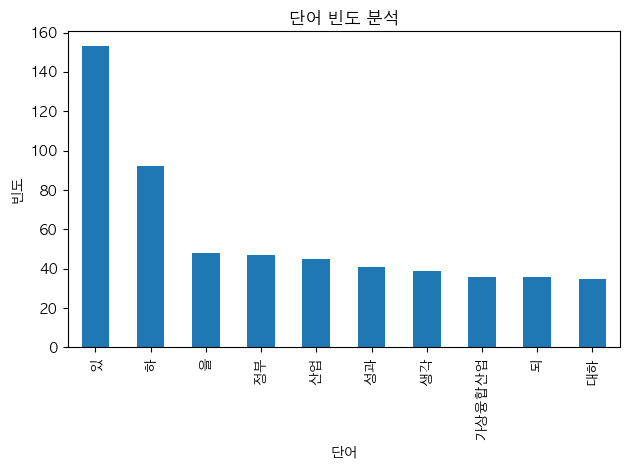

In [60]:
# 텍스트 정리 함수
def clean_text(text):
    text = re.sub(r"[^\w\sㄱ-ㅎㅏ-ㅣ가-힣]", "", text)  # 한글, 숫자, 알파벳만 남김
    return re.sub(r"\s+", " ", text).strip()  # 연속된 공백 제거

# 형태소 분석 및 필터링 함수
def filter_tokens(text):
    pos_tags = komoran.pos(text)
    desired_pos = {"NNG", "NNP", "VV", "VA"}  # 명사, 동사, 형용사
    return [word for word, tag in pos_tags if tag in desired_pos]

# 빈도 분석 함수
def analyze_frequency(tokens):
    counter = Counter(tokens)
    return counter.most_common()

# 시각화 함수
def visualize_frequencies(frequencies, top_n=10, output_file=None):
    df = pd.DataFrame(frequencies[:top_n], columns=["단어", "빈도"])
    df.plot.bar(x="단어", y="빈도", legend=False)
    plt.title("단어 빈도 분석")
    plt.xlabel("단어")
    plt.ylabel("빈도")
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file)
    plt.show()



# 텍스트 정리 및 분석
cleaned_text = clean_text(text)
filtered_tokens = filter_tokens(cleaned_text)
frequencies = analyze_frequency(filtered_tokens)

# 결과 출력
print("단어 빈도 분석 결과:")
for word, freq in frequencies:
    print(f"{word}: {freq}")

# 상위 10개 단어 시각화
visualize_frequencies(frequencies, top_n=10, output_file="word_frequencies.png")